Load in df data from prev notebook.
* `munge_pt2_disease_hierarchy.ipynb`
*  `df_temp = pd.concat([X,y])
df_temp.to_parquet("features_data_export.parquet")`

Run comparative  evaluation between ml models + output figure

In [17]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import f_classif, chi2,SelectFromModel,SelectKBest,mutual_info_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,GroupKFold,cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report,average_precision_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFpr, SelectFdr
import re
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.compose import ColumnTransformer

from catboost import Pool, CatBoostClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, RepeatedStratifiedKFold
from scipy.stats import ttest_rel, chi2, ttest_ind
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import seaborn as sns

from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from sklearn import set_config
set_config(transform_output = "pandas")

In [18]:
DO_DL= True
SAVE_CANDIDATES = True # save output predicted candidates - overwrites
DO_LEAKY_FS =False#True# # leaky train on train feature sel..  - only used during debugging

FASTRUN = False# True
# FASTRUN = True

In [19]:
from re import sub

def prettify_feature_names(s):
    """replace _ with space and camel case and additional changes to make output feature names look nicer"""
    
    s = s.replace("_000000"," ").replace("pct","Percent").replace("dl_","Text Embedding Vector ").replace("ENSG00000","ENSG ")
    s = s.replace("Evidencecount","Evidence count").replace("byDisease","by Disease")
    s = sub(r"(_|-)+", " ", s).title()
    return ''.join(s)

#### Export data

In [20]:
if DO_DL:
    df = pd.read_parquet("features_data_DL_export.parquet")
else: 
    df = pd.read_parquet("features_data_export.parquet") # no deep learning/text features
    
df = df.convert_dtypes(convert_string=False) ## parses ~ 990 floats ot int. Note that memory usage isn't actualy lowered/;
df["has_children"] = df["has_children"].astype(int)

if FASTRUN:
    df = df.sample(frac=0.04)
df

,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314,0
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414,0
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476,0
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645,0
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215,0
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667,0
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982,0


In [21]:
%%time
if DO_LEAKY_FS or FASTRUN:
    K_Feats = 5 if FASTRUN else 3500
    ## leaky FS 
    # fs = SelectFpr(score_func=chi2,alpha=0.25)
    fs = Pipeline([ ("var",VarianceThreshold(0.0005)),
        ("SimpleImputer",SimpleImputer(strategy="most_frequent")),
#         ("statf",SelectFpr(score_func= f_classif,alpha=0.01)),
#           ("statk",SelectKBest(score_func= f_classif,k=K_Feats))
                  ])
    X = df.drop(columns="has_children").select_dtypes("number")
    X.columns = X.columns.astype(str)
    X.fillna(0,inplace=True)
    y = df["has_children"]
    fs.fit(X,y)
    ##LEAKY!!!: 
    print("pre filt",df.shape) # 4182
    df = df.filter(["source","has_children","Phenotype_counts"]+list(fs.get_feature_names_out()),axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy() # drop a col getting duplicated  Phenotype_counts
    X = X.filter(["source","Phenotype_counts"]+list(fs.get_feature_names_out()),axis=1)
    print(df.shape)  # 40281

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [22]:
df

,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767,has_children
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314,0
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414,0
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476,0
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645,0
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215,0
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667,0
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982,0


In [23]:
X = df.drop(columns=["has_children"],errors="ignore")
print(X.shape)
y = df["has_children"]
assert y.dropna().sum()>50
print(y.agg(["count","mean","sum"]).round(2))

assert y.shape[0]==X.shape[0]

(17222, 3200)
count    17222.00
mean         0.34
sum       5848.00
Name: has_children, dtype: float64


In [24]:
# ## OPT: String / categorical feature of disease source. may be leak or bias??
# X["source"] = [i[0] for i in list(X.index.str.split("_",expand=True))]## ORIG before index change with grp#[:,0]
## warning - ordinal instead of OHE encoding
 # useful for running other models
lbl = LabelEncoder().fit(X.source)
cat_col = X.columns.get_loc("source")
X.iloc[:,cat_col]
X.iloc[:,cat_col] = lbl.transform(X.source)
X

,animal_model,All_ICD_counts,num_parents,pct_somatic_mutation,affected_pathway_ratio_to_biggest,num_therapeuticAreas,pct_animal_model,animal_model_ratio_to_smallest,rna_expression_ratio_to_smallest,literature_ratio_to_biggest,...,dl_758,dl_759,dl_760,dl_761,dl_762,dl_763,dl_764,dl_765,dl_766,dl_767
name,,,,,,,,,,,,,,,,,,,,,
10p11.21p12.31 microdeletion syndrome,2,0,1,0.0,0.0,16,50.0,1.0,0.0,0.0,...,0.038011,-0.008973,-0.011922,-0.029698,0.030446,0.015639,-0.01488,-0.054027,-0.022872,0.01314
10q22.3q23.3 microduplication syndrome,4,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.031007,0.009407,0.028488,-0.023618,0.013682,-0.000997,-0.021142,-0.05629,-0.03345,-0.007414
11p15.4 microduplication syndrome,0,0,3,0.0,0.0,16,0.0,0.0,0.0,0.0,...,0.01897,0.016148,-0.016285,-0.033168,0.020486,0.01425,-0.003042,-0.081733,0.039752,0.008476
12p12.1 microdeletion syndrome,2,0,0,0.0,0.0,16,66.6667,2.0,0.0,0.0,...,0.020466,-0.021291,-0.043856,-0.018003,0.003387,0.038978,-0.032084,-0.048926,-0.005518,-0.003645
12q14 microdeletion syndrome,169,0,0,0.0,0.0,16,100.0,1.0,0.0,0.0,...,0.01915,-0.006823,-0.014591,-0.029553,0.015847,0.070078,0.016362,-0.062399,0.046976,-0.007567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zygodactyly type 1,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.014381,0.005693,0.02738,-0.031438,-0.023347,0.008283,0.025569,-0.041679,0.053067,-0.018215
zygodactyly type 2,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.014625,-0.001348,0.010197,-0.03201,-0.018714,-0.008233,0.016151,-0.036483,0.029733,-0.026667
zygodactyly type 3,0,0,0,0.0,0.0,32,0.0,0.0,0.0,0.0,...,0.016962,-0.007073,0.012932,-0.019908,-0.003233,0.015318,0.002056,-0.046798,0.044081,-0.021982


* alt: could use repeatedKFold (note that then we wouldn't get per sample multiple predictions trivially);
```
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=7, random_state=1)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
```

In [25]:
num_columns = X.select_dtypes(include=['number']).columns.tolist()
cat_columns = X.select_dtypes(include=["O",'object',"string"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label', OneHotEncoder(handle_unknown='ignore',min_frequency=2,sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)])


* Note: SqtBalanced was out default picked model, as a good prior to imbalanced data. 
    I include results with the default catboost (no weighting) As a contrast, but this was not used when ceating and picking the model initially.  

In [26]:
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),('LogisticRegression',LogisticRegression())])
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),('RF',RandomForestClassifier(n_jobs=-2))])

clf_cb = CatBoostClassifier(cat_features=["source"],verbose=False,auto_class_weights = "SqrtBalanced", task_type="GPU")   
clf_cb2 = CatBoostClassifier(cat_features=["source"],verbose=False, task_type="GPU")  
clf_histgb = Pipeline(steps=[('preprocessor', preprocessor),('histgb',HistGradientBoostingClassifier())])
clf_cb_proc = Pipeline(steps=[('preprocessor', preprocessor),('cb',CatBoostClassifier(auto_class_weights = "SqrtBalanced",
                                                                                      verbose=False, task_type="GPU"))])
# clf_knn =  Pipeline(steps=[('preprocessor', preprocessor),('KNN',KNeighborsClassifier(n_neighbors=25,n_jobs=-2))])
clf_svc =  Pipeline(steps=[('preprocessor', preprocessor),('LinearSVM',SGDClassifier())])

In [27]:
cv = StratifiedKFold(n_splits=2 if FASTRUN else 5, random_state=42, shuffle=True)


In [28]:
%%time
# # list of models to evaluate: 
classifiers = {
    'Logistic Regression': clf_lr,
    'Random Forest': clf_rf,
    "HistGradientBoosting":clf_histgb,
    "SVM-SVC":clf_svc,
    "catboost+preproccess":clf_cb_proc,
    # "KNN": clf_knn,
    'CatBoost-base': clf_cb2,
    'CatBoost': clf_cb ## SqrtBalanced
}

# Initialize the data frame to store the results
results_df = pd.DataFrame()
# Define the scoring metrics
scoring = {'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
            'pr_auc': make_scorer(average_precision_score, needs_proba=True),
          'prec': 'precision',"recall":"recall","acc":"accuracy"}


for clf_name, clf in classifiers.items():
    print(clf_name)
    # Perform cross-validation
    scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, return_train_score=False)
    print(scores)
    # Store the results into the data frame
    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
    
    results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
    results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
    results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
    results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
    results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
    results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()

###############################    
### baseline models
clf_name = "Source Baseline"
scores = cross_validate(LogisticRegression(), OneHotEncoder(handle_unknown='ignore',min_frequency=2,sparse_output=False).fit_transform(X[["source"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()

clf_name = "Phenotype Baseline"
scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["Phenotype_counts"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()

try:
    clf_name = "Max Phenotype frequency Baseline"
    scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["max_phenotype_frequency"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
    results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
    results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
    results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
    results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
    results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
    results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
except: 
    print("max pheno feature missing")
    
clf_name = "# Siblings Baseline"
scores = cross_validate(LogisticRegression(), numeric_transformer.fit_transform(X[["num_siblings"]]), y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()

###
if not FASTRUN:
    print("Catboost Without Text Features")
    clf_name = "Catboost Without Text Features"
    X2 = X.drop(columns=list(X.columns[X.columns.str.contains("dl_")]),errors="ignore")
    scores = cross_validate(clf_cb, X2, y, cv=cv, scoring=scoring, return_train_score=False)

    results_df.loc[clf_name, 'ROCAUC Mean'] = scores['test_roc_auc'].mean()
    results_df.loc[clf_name, 'ROCAUC SD'] = scores['test_roc_auc'].std()
    results_df.loc[clf_name, 'PRAUC Mean'] = scores['test_pr_auc'].mean()
    results_df.loc[clf_name, 'PRAUC SD'] = scores['test_pr_auc'].std()
    results_df.loc[clf_name, 'Precision Mean'] = scores['test_prec'].mean()
    results_df.loc[clf_name, 'Precision SD'] = scores['test_prec'].std()
    results_df.loc[clf_name, 'Recall Mean'] = scores['test_recall'].mean()
    results_df.loc[clf_name, 'Recall SD'] = scores['test_recall'].std()
    results_df.loc[clf_name, 'Acc Mean'] = scores['test_acc'].mean()
    results_df.loc[clf_name, 'Acc SD'] = scores['test_acc'].std()
#########
results_df.dropna(how="all",axis=10,inplace=True)
results_df = results_df.round(4)*100
results_df.sort_values("ROCAUC Mean",inplace=True)
# Print the result
print(results_df)

if SAVE_CANDIDATES:
    if not FASTRUN: 
        results_df.dropna(how="all",axis=0).to_csv("./outputs/Table-1-Known disease subtype models evaluation.csv") # Table-1-Known disease submanifestation prediction.csv

Logistic Regression


/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

{'fit_time': array([4.89751101, 5.41284204, 4.91256952, 4.83964682, 5.25217962]), 'score_time': array([0.71204257, 0.91340661, 0.86050797, 0.8795228 , 0.97477198]), 'test_roc_auc': array([0.81179882, 0.80250399, 0.79766533, 0.8154177 , 0.81426757]), 'test_pr_auc': array([0.67205139, 0.63808632, 0.63345963, 0.65302815, 0.64389242]), 'test_prec': array([0.66211878, 0.66803615, 0.66161616, 0.68143813, 0.66177669]), 'test_recall': array([0.70512821, 0.69487179, 0.67236955, 0.69717707, 0.69401709]), 'test_acc': array([0.77764877, 0.77910015, 0.77206736, 0.78658537, 0.77555168])}
Random Forest
{'fit_time': array([5.66682005, 4.64588332, 4.5865581 , 4.46162796, 4.60317802]), 'score_time': array([0.93564844, 0.88565731, 0.89581227, 0.88433671, 0.93375158]), 'test_roc_auc': array([0.86232911, 0.86250099, 0.86263492, 0.86678217, 0.87520691]), 'test_pr_auc': array([0.79305867, 0.79377233, 0.78189541, 0.7945839 , 0.80980201]), 'test_prec': array([0.81495564, 0.84063745, 0.83333333, 0.84      , 0.8

/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    y_pred = method_caller(clf, "predict_proba", X, pos_label=self._get_pos_label())
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/utils/_response.py", line 73, in _get_response_values
    prediction_method = _check_response_method(estimator, response_method)
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/u

{'fit_time': array([5.5096724 , 5.89449573, 7.34001398, 6.76827359, 7.01389885]), 'score_time': array([0.34069896, 0.49319315, 0.50329947, 0.33433151, 0.4964242 ]), 'test_roc_auc': array([nan, nan, nan, nan, nan]), 'test_pr_auc': array([nan, nan, nan, nan, nan]), 'test_prec': array([0.6388664 , 0.64484452, 0.63590178, 0.66065292, 0.64922322]), 'test_recall': array([0.67435897, 0.67350427, 0.64242943, 0.6578272 , 0.67863248]), 'test_acc': array([0.75994194, 0.76313498, 0.75377468, 0.76916376, 0.76626016])}
catboost+preproccess
{'fit_time': array([ 93.97314787,  94.32674146,  90.89267755,  74.1594913 ,
       120.68586302]), 'score_time': array([1.08061457, 0.92145252, 0.93376827, 0.88384867, 1.06076789]), 'test_roc_auc': array([0.88734442, 0.89472978, 0.89107737, 0.89723235, 0.90199919]), 'test_pr_auc': array([0.8346124 , 0.84168259, 0.83360587, 0.84706803, 0.85085998]), 'test_prec': array([0.78896418, 0.8138833 , 0.80991736, 0.81516096, 0.81584158]), 'test_recall': array([0.6965812 , 0

/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 399, in _score
    y_pred = method_caller(clf, "predict_proba", X, pos_label=self._get_pos_label())
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/utils/_response.py", line 85, in _get_response_values
    y_pred = prediction_method(X)
  File "/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 578, in predict_proba
 

{'fit_time': array([2.26290488, 2.25623369, 2.24567127, 2.33697057, 2.26918221]), 'score_time': array([1.86899042, 1.84744906, 1.83904099, 1.81580734, 1.99489474]), 'test_roc_auc': array([nan, nan, nan, nan, nan]), 'test_pr_auc': array([nan, nan, nan, nan, nan]), 'test_prec': array([nan, nan, nan, nan, nan]), 'test_recall': array([nan, nan, nan, nan, nan]), 'test_acc': array([nan, nan, nan, nan, nan])}
CatBoost-base
{'fit_time': array([62.24008918, 63.247823  , 63.2285006 , 61.4874537 , 62.7714262 ]), 'score_time': array([1.54379892, 1.53567529, 1.39271116, 1.48434758, 1.42341614]), 'test_roc_auc': array([0.88265051, 0.89018616, 0.88647609, 0.89294955, 0.89847327]), 'test_pr_auc': array([0.82712001, 0.83354402, 0.82593663, 0.84144945, 0.84828421]), 'test_prec': array([0.79417671, 0.81198347, 0.8113804 , 0.81808623, 0.81736527]), 'test_recall': array([0.67606838, 0.67179487, 0.65868263, 0.66552609, 0.7       ]), 'test_acc': array([0.83047896, 0.83570392, 0.83217189, 0.83623693, 0.844947

/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469

Catboost Without Text Features
                                  ROCAUC Mean  ROCAUC SD  PRAUC Mean  \
# Siblings Baseline                     52.35       0.52       35.28   
Source Baseline                         55.86       0.55       37.67   
Phenotype Baseline                      66.42       0.42       44.60   
Max Phenotype frequency Baseline        66.44       0.50       44.31   
Logistic Regression                     80.83       0.70       64.81   
Catboost Without Text Features          85.81       0.52       76.27   
Random Forest                           86.59       0.49       79.46   
CatBoost-base                           89.01       0.54       83.53   
CatBoost                                89.14       0.52       83.60   
HistGradientBoosting                    89.40       0.49       84.35   
catboost+preproccess                    89.45       0.50       84.16   
SVM-SVC                                   NaN        NaN         NaN   
KNN                              

In [34]:
display(results_df)

,ROCAUC Mean,ROCAUC SD,PRAUC Mean,PRAUC SD,Precision Mean,Precision SD,Recall Mean,Recall SD,Acc Mean,Acc SD
# Siblings Baseline,52.35,0.52,35.28,0.32,0.00,0.00,0.00,0.00,66.04,0.01
Source Baseline,55.86,0.55,37.67,0.26,57.67,2.15,3.63,0.42,66.36,0.08
Phenotype Baseline,66.42,0.42,44.60,0.34,0.00,0.00,0.00,0.00,66.04,0.01
Max Phenotype frequency Baseline,66.44,0.50,44.31,0.38,0.00,0.00,0.00,0.00,66.04,0.01
Logistic Regression,80.83,0.70,64.81,1.36,66.70,0.76,69.27,1.09,77.82,0.48
Catboost Without Text Features,85.81,0.52,76.27,0.51,68.99,1.38,71.61,0.77,79.42,0.72
Random Forest,86.59,0.49,79.46,0.89,83.65,1.26,53.45,1.47,80.64,0.50
CatBoost-base,89.01,0.54,83.53,0.85,81.06,0.86,67.44,1.41,83.59,0.50
CatBoost,89.14,0.52,83.60,0.80,76.84,0.67,73.34,1.48,83.44,0.55
HistGradientBoosting,89.40,0.49,84.35,0.86,80.74,0.88,69.27,1.38,83.95,0.50


## FIG 2
### output rocauc, prauc for selection of models
* done seperately since we need to rerun anyway , and this way we can easily control which models to use

/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ddofer/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

baseline


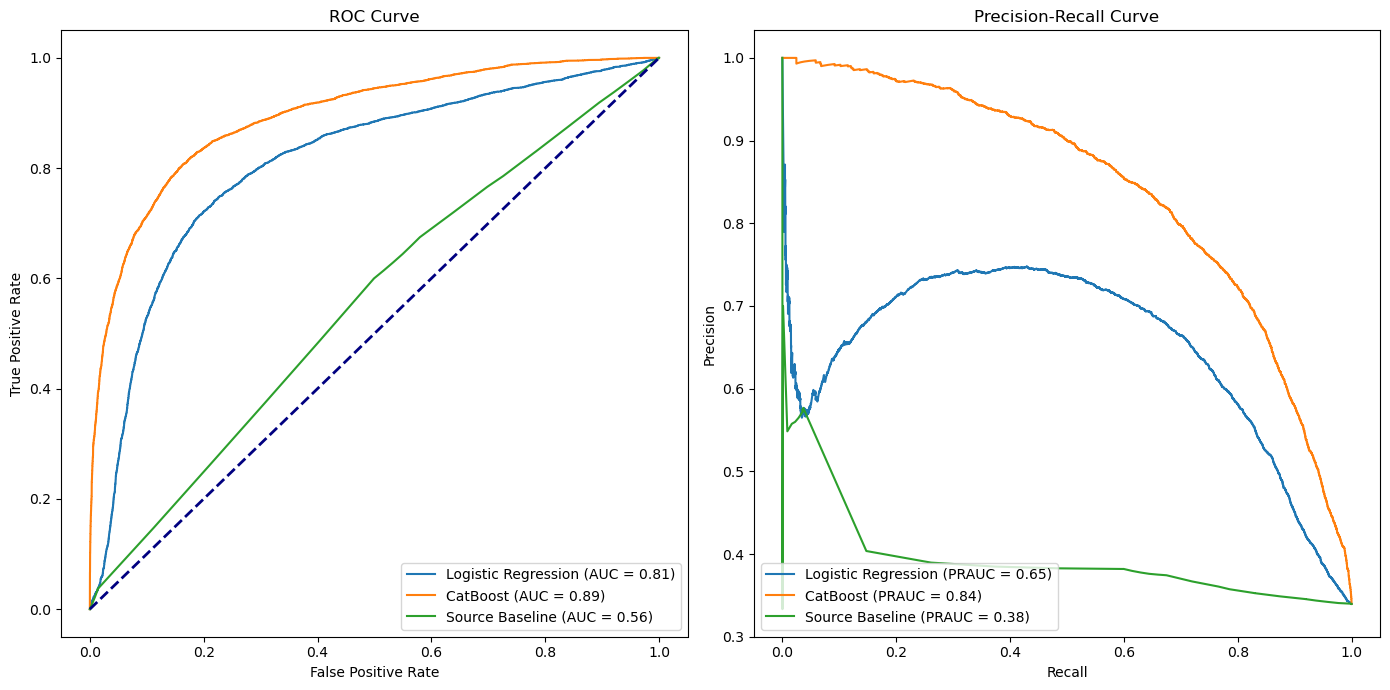

CPU times: user 7min 11s, sys: 1min 22s, total: 8min 33s
Wall time: 5min 6s


In [37]:
%%time
# Assuming clf_lr, clf_rf, clf_cb are predefined classifiers
classifiers = {
    'Logistic Regression': clf_lr,
    'CatBoost': clf_cb_proc#clf_cb # SqrtBalanced
}

# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 14))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))

for clf_name, clf in classifiers.items():
    # Predict probabilities for ROC and PR curves
    y_pred = cross_val_predict(estimator=clf, X=X, y=y, cv=cv, method="predict_proba")[:,1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc = (round(roc_auc_score(y, y_pred) , 2))
    ax1.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc})')
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    ap = (round(average_precision_score(y, y_pred), 2))
    ax2.plot(recall, precision, label=f'{clf_name} (PRAUC = {ap})')
print("baseline")
# Baseline Model
clf_name = "Source Baseline"
y_pred = cross_val_predict(estimator=LogisticRegression(), X=OneHotEncoder(handle_unknown='ignore',
                                                                           min_frequency=2,sparse_output=False).fit_transform(X[["source"]]),
                           y=y, cv=cv, n_jobs=2, method="predict_proba")[:,1]

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred)
auc = (round(roc_auc_score(y, y_pred), 2))
ax1.plot(fpr, tpr, label=f'{clf_name} (AUC = {auc})')

# PR Curve
precision, recall, _ = precision_recall_curve(y, y_pred)
ap = (round(average_precision_score(y, y_pred), 2))
ax2.plot(recall, precision, label=f'{clf_name} (PRAUC = {ap})')

# Plot 50 AUC baseline for ROC curve
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Configure plots
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc='lower left')
plt.tight_layout()

##TODO: not actually saved to output>
if SAVE_CANDIDATES:
    if not FASTRUN:
        plt.savefig('./outputs/Fig-2-roc_pr_curves.png', dpi=840)
        
plt.show()